# Varation in vertex properties across the cortex

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import neuroboros as nb
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
nc = 10
colors = np.concatenate(
    [sns.color_palette("mako", nc)[1:],
     [[0.9, 0.9, 0.9]],
     sns.color_palette("rocket", nc)[1:][::-1]],
    axis=0)
cmap = mpl.colors.LinearSegmentedColormap.from_list('mako_rocket', colors)

In [3]:
vertex_properties = {}
spaces = ['fsavg-ico32', 'fslr-ico32', 'onavg-ico32']

for space in spaces:
    ivd = []
    for lr in 'lr':
        coords, faces = nb.geometry('midthickness', lr, space)
        surf = nb.surface.Surface(coords, faces)
        neighbors = surf.neighbors
        distances = nb.distances(lr, space)
        d = []
        for i, nbrs in enumerate(neighbors):
            d.append(distances[i, nbrs].mean())
        d = np.array(d)
        ivd.append(d)
    vertex_properties['ivd', space] = np.concatenate(ivd)

In [4]:
for space in spaces:
    counts = []
    for lr in 'lr':
        sls = nb.sls(lr, 20, space, mask=False)
        counts += [len(_) for _ in sls]
    vertex_properties['sl_count', space] = np.array(counts)

In [7]:
for space in spaces:
    area = [nb.morphometry('area.mid', lr, space) for lr in 'lr']
    masks = [nb.mask(lr, space) for lr in 'lr']
    vertex_properties['area', space] = np.concatenate([_[m] for _, m in zip(area, masks)])

ivd [0.08352656 0.07902751]
sl_count [0.04734505 0.0439038 ]
area [0.04633051 0.0447125 ]


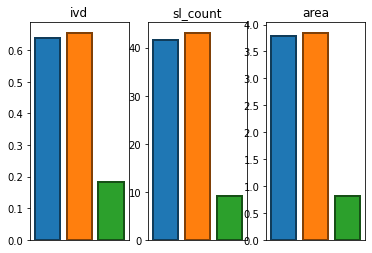

In [15]:
properties = ['ivd', 'sl_count', 'area']
colors = np.array(sns.color_palette('tab10'))
fig, axs = plt.subplots(1, 3, figsize=(6, 4))
for prop, ax in zip(properties, axs):
    stds = np.array([np.std(vertex_properties[prop, space], ddof=1) for space in spaces])
    for i, space in enumerate(spaces):
        c = colors[i]
        ax.bar(i, stds[i], color=c, edgecolor=c * 0.5, label=space, linewidth=2)
    ax.set_xticks([])
    ax.set_title(prop)
    print(prop, stds[2]**2 / stds[:2]**2)
plt.show()

In [4]:
sls_counts = {}
for space in ['fsavg-ico32', 'fslr-ico32', 'onavg-ico32']:
    counts = []
    for lr in 'lr':
        sls = nb.sls(lr, 20, space, mask=False)
        counts += [len(_) for _ in sls]
    sls_counts[space] = np.array(counts)

In [11]:
sls_counts

{'fsavg-ico32': array([145, 136, 187, ...,  91,  96,  95]),
 'fslr-ico32': array([151, 156, 130, ...,  85,  88,  85]),
 'onavg-ico32': array([119, 123, 122, ..., 118, 116, 115])}

In [18]:
mean, vmin, vmax

(4.811790201137479, 4.118643020577534, 5.504937381697425)

In [19]:
np.exp([mean, vmin, vmax])

array([122.95152858,  61.47576429, 245.90305716])

In [21]:
np.exp(ticks)

array([ 43.46992981,  73.1074163 , 122.95152858, 206.77899927,
       347.75943847])

In [27]:
for i, space in enumerate([f'fsavg-ico{ico}', f'fslr-ico{ico}', f'onavg-ico{ico}']):
    d = data_dict[space]
    nb.percentile(np.exp(d))

[ 62.  85.  95. 108. 122. 135. 146. 158. 171. 190. 309.]
[ 57.  86.  96. 109. 122. 133. 143. 156. 171. 192. 336.]
[ 99. 115. 117. 119. 120. 122. 123. 125. 127. 132. 218.]


In [33]:
ico = 32
data_dict = {key: np.log(val) for key, val in sls_counts.items()}
mean = data_dict[f'onavg-ico{ico}'].mean()
vmin, vmax = mean - np.log(2) * 1.5, mean + np.log(2) * 1.5
ticks = np.linspace(0, 1, 7) * (vmax - vmin) + vmin

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
lim = [vmin, vmax]
mpl.rcParams['font.family'] = 'Arial'
fig = plt.figure(figsize=(4.5/2.54, 4.2/2.54), dpi=600)


for i, space in enumerate([f'fsavg-ico{ico}', f'fslr-ico{ico}', f'onavg-ico{ico}']):
    d = data_dict[space]
    y = [0.85, 0.7, 0.3][i]
    ax = fig.add_axes([0.05, y, 0.9, 0.2])
    bins = np.linspace(lim[0], lim[1], 51)
    for k in ['left', 'right', 'top']:
        ax.spines[k].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    amplitudes, _, patches = ax.hist(
        d, bins, orientation='vertical', density=True, clip_on=False)
    for i, p in enumerate(patches):
        v = bins[[i, i+1]].mean()
        c = cmap(norm(v))
        p.set_facecolor(c)
    ax.set_xlim(lim)
    ax.set_ylim([0, {64:9, 32:4.5}[ico]])
    ax.set_facecolor([1.0, 1.0, 1.0, 0.0])
    ax.annotate(space, (0.05, y+0.09), xycoords='figure fraction', size=7,
               va='top', ha='left')

ax2 = fig.add_axes([0.05, 0.14, 0.9, 0.05])
v = np.linspace(vmin, vmax, 10001)
c = cmap(norm(v))

ax2.imshow(c[np.newaxis], extent=[0, 1, 0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_yticks([])
ax2.set_xticks(interp1d(lim, [0, 1], axis=0)(ticks))
ax2.set_xticklabels([f'{np.exp(_):.0f}' for _ in ticks], size=5)
ax2.set_xlabel('# of vertices in a 20 mm searchlight', size=7, labelpad=0)
ax2.set_aspect('auto')
ax2.tick_params(axis='both', pad=1, length=3, labelsize=6)

annots = [(0.04, 'less', 'left'), (0.5, 'better', 'center'),
          (0.96, 'more', 'right')]
for x, txt, ha in annots:
    ax2.annotate(txt, (x, 0.21), xycoords='figure fraction', size=7, ha=ha)

plt.savefig(f'sl_vertex_count_ico{ico}.png', dpi=600)
plt.close()

:::::{div} full-width
::::{grid}
:gutter: 1

:::{grid-item-card} histogram
![Searchlight vertex count](sl_vertex_count_ico32.png)
:::

::::
:::::

## Small numerical differences
The numbers based on the ``ouroboros`` package slightly differ from those reported in the manuscript.
- In the manuscript, the inter-vertex distance was computed by first averaging across all neighbors, and then averaging across all participants; In this Jupyter Book, the distance was first averaged across all participants, and then averaged across neighbors. Note that we used 95% trimmed mean when averaging across participants, and therefore these two steps are not commutative, and small numerical differences can occur based on the order of the operations.
- Resampling vertex properties from the native space of each participant.
- fMRIPrep version.
